In [ ]:
%%bash
pip install matplotlib aiohttp

# 安装中文字体
yum install wqy-zenhei-fonts wqy-microhei-fonts fontconfig
# 检查字体是否安装成功
fc-list :lang=zh
fc-cache


In [1]:
%%bash
# 安装python依赖
#pip install grpcio grpcio-tools requests
#pip install numpy matplotlib

# 生产grpc的proto文件
cat > StockChange.proto <<EOF
syntax = "proto3";

service Greeter {
  // 定义一个简单的 RPC 方法
  rpc StockChange (StockRequest) returns (StockReply);
}

// 定义请求和响应消息
message StockRequest {
  string stock_code = 1;
  string stocck_name = 2;
  double latest_price= 3;
  string message = 4;
}

message StockReply {
  int32 code = 1;
  string body = 2;
}
EOF

# 生产grpc代码
python -m grpc_tools.protoc -I. --python_out=. --grpc_python_out=. StockChange.proto

display
Signal received: 2
Shutting down...


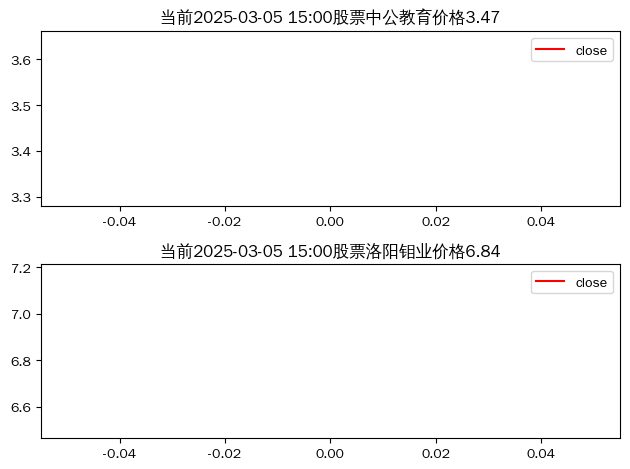

exit show...
exit get_data
Error while connecting to 0.002607: exit data


Signal received: 2
Shutting down...
Signal received: 15
Shutting down...


In [ ]:
import asyncio
import aiohttp
from functools import reduce
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import signal
import threading
import time
from IPython.display import display, clear_output


font_dirs = '/usr/share/fonts'
font_files = matplotlib.font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    matplotlib.font_manager.fontManager.addfont(font_file)
matplotlib.rcParams['font.family'] = 'WenQuanYi Zen Hei'
matplotlib.rcParams['axes.unicode_minus'] = False


def get_stock_url(stock_code):
    base_url = 'https://29.push2.eastmoney.com/api/qt/stock/trends2/sse'
    query_params = {
        "fields1": "f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f17",
        "fields2": "f51,f52,f53,f54,f55,f56,f57,f58",
        "mpi": "1000",
        "ut": "fa5fd1943c7b386f172d6893dbfba10b",
        "secid": f"{stock_code}",
        "ndays": 1,
        "iscr": 0,
        "iscca": 0,
        "wbp2u": "|0|0|0|web"
        }
    query_string = reduce(lambda x,y:str(x)+'&'+str(y), map(lambda x:str(x)+'='+str(query_params.get(x, '')), query_params))
    url = f"{base_url}?{query_string}"
   
    return url

def get_url_headers(stock_code):
    stock_exchange = {
        "0": "sz",
        "1": "sh"
        }
    ex_key, code = stock_code.split(".")
    headers = {
        'Accept': 'text/event-stream',
        'Accept-Language':  'zh-CN,zh;q=0.9,en;q=0.8,en-GB;q=0.7,en-US;q=0.6',
        'Cache-Control':  'no-cache',
        'Connection':  'keep-alive',
        'Origin':  'https://quote.eastmoney.com',
        'Referer':  f'https://quote.eastmoney.com/{stock_exchange[ex_key]}{code}.html',
        'Sec-Fetch-Dest':  'empty',
        'Sec-Fetch-Mode':  'cors',
        'Sec-Fetch-Site':  'same-site',
        'User-Agent':  'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/133.0.0.0 Safari/537.36 Edg/133.0.0.0',
        'sec-ch-ua':  '"Not(A:Brand";v="99", "Microsoft Edge";v="133", "Chromium";v="133"',
        'sec-ch-ua-mobile':  '?0',
        'sec-ch-ua-platform':  '"Windows"'
        }
    return headers

def init_stock_data(stock_code, **kwargs):
    global stock_datas
    name = kwargs.get("name")
    if not name:
        return
    stock_datas[stock_code] = {
        "name": name,
        "trad_time": [],
        "open_price":[],
        "close_price":[],
        "average_price":[]
    }

def update_stock_data(stock_code, **kwargs):
    global stock_datas
    for k in ['open_price', 'close_price', 'average_price']:
        stock_datas[stock_code][k].append(float(kwargs.get(k, 0)))
    stock_datas[stock_code]['trad_time'].append(kwargs.get('trad_time', ''))
    # print(f"stock_datas:{stock_datas}")
    

def parse_data(stock_code, data):
    if not data:
        return
    data = data[5:]
    data = json.loads(data)
    resp_data = data.get("data", {}) or {}
    if not resp_data:
        return 
    
    stock_name = resp_data.get("name")
    if stock_name:
        init_stock_data(stock_code=stock_code, name=stock_name)
    trends_datas = resp_data.get("trends")
    if not trends_datas:
        print("暂时没有trends数据")
        return
    
    lastest_trend_data = trends_datas[-1]
    print(f"lastest_trend_data:{lastest_trend_data}")
    trad_time, open_price, close_price, high_price, \
        low_price, trad_volume, trad_amount, \
            average_price = lastest_trend_data.split(',')
    # print(f"{trad_time} {close_price}")
    update_stock_data(
        stock_code=stock_code, trad_time=trad_time, open_price=open_price, 
        close_price=close_price, high_price=high_price, low_price=low_price, 
        trad_volume=trad_volume, trad_amount=trad_amount, average_price=average_price
        )
        
        
async def get_stock_data(stock_code):
    url = get_stock_url(stock_code)
    headers = get_url_headers(stock_code)
    try:
        timeout = aiohttp.ClientTimeout(total=None, connect=None, sock_connect=None, sock_read=None)
        async with aiohttp.ClientSession(timeout=timeout) as session:
            async with session.get(url, headers=headers) as response:
                if response.status == 200:
                    async for line in response.content:
                        if line:
                            message = line.decode('utf-8').strip()
                            if message:
                                parse_data(stock_code, message)
                        if stop_event.is_set():
                            print("exit get_data")
                            raise Exception("exit data")
                else:
                    print(f"Failed to connect to {url}, Status code: {response.status}")
                
    except Exception as e:
        print(f"Error while connecting to {stock_code}: {e}")
        # raise e


def get_stocks(stock_codes):
    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)
    tasks = [get_stock_data(code) for code in stock_codes]
    loop.run_until_complete(asyncio.gather(*tasks))


def display_data(stock_codes):
    global stock_datas
    fig, axes = plt.subplots(len(stock_codes), 1)
    for i,code in enumerate(stock_codes):
        st_data = stock_datas.get(code)
        if not st_data:
            continue
        name, close_price, trad_time = st_data["name"], st_data["close_price"], st_data["trad_time"]
        if not close_price:
            continue
        axes[i].plot(range(len(close_price)), close_price, 'r-', label='close')
        axes[i].set_title(f"当前{trad_time[-1]}股票{name}价格{close_price[-1]}")
        axes[i].legend()

    plt.tight_layout()
    plt.show()

def stock_show(stock_codes):
    while not stop_event.is_set():
        clear_output(wait=True)
        print("display")
        display_data(stock_codes)
        time.sleep(2)
    else:
        print("exit show...")


def signal_handler(sig, frame):
    print("Signal received:", sig)
    print("Shutting down...")
    # 在接收到信号后，设置一个标志变量来停止所有线程
    stop_event.set()
    

"""
中公教育： 0.002607
洛阳钼业： 1.603993
"""
stock_codes = ["0.002607", "1.603993"]
# stock_data = {"code": {"name":"", "open_price":[], "close_price":[], "average_price":[]}}
stock_datas = {}
signal.signal(signal.SIGINT, signal_handler)
signal.signal(signal.SIGTERM, signal_handler)

stop_event = threading.Event()

# 创建两个线程
thread1 = threading.Thread(target=get_stocks, args=(stock_codes,))
thread2 = threading.Thread(target=stock_show, args=(stock_codes,))

# 启动线程
thread1.start()
thread2.start()

# 等待线程执行完毕
thread1.join()
thread2.join()
